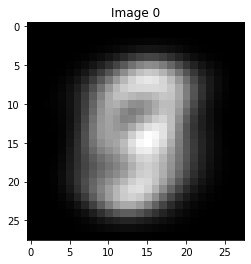

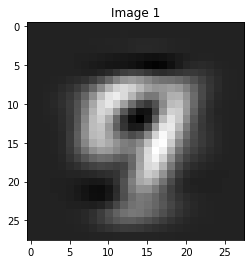

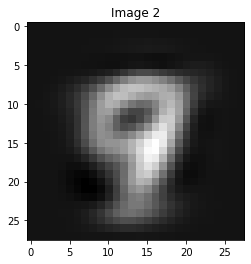

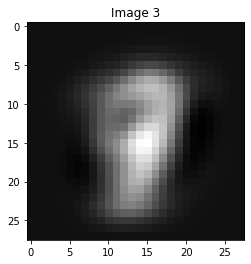

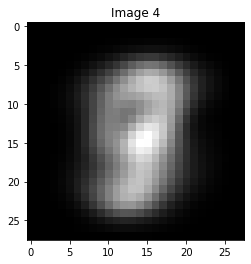

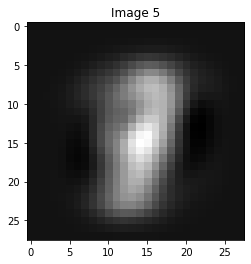

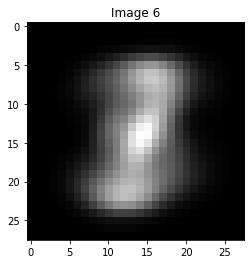

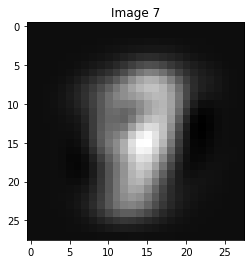

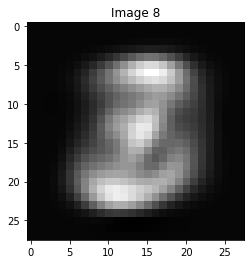

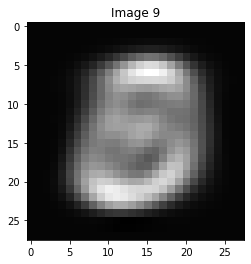

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.datasets import mnist
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
# Multivariate Gauss
def multivariate(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))
#import data
(X_train,y_train),(X_test,y_test)=mnist.load_data()
data=X_train
data=data.reshape(data.shape[0],data.shape[1]*data.shape[2])/255
pca=PCA(n_components=2)
pca.fit(data)
data=pca.fit_transform(data)
N=10 #Number of bins
lenDataset = data.shape[0]
dimData=data.shape[1]
#normalized histogram of loaded datase
hist, bins = np.histogramdd(data, bins=N, density=True)
center=np.zeros((N,dimData))
dx=bins[0][1]-bins[0][0]
for i in range(dimData):
    center[:,i]=(bins[i][:-1]+bins[i][1:])/2
#Silverman's Rule to find optimal bandwidth    
H1=np.zeros((dimData,dimData))
for i in range(dimData):
    H1[i,i]=((4/(dimData+2))**(1/(dimData+4))*(lenDataset**(-1/(dimData+4)))*np.std(data[i]))**2


#Our second approach to calculate optimal bandwidth h using least-squares cross validation
number_test=10
cov=[]
for i in range(number_test):
    cov.append(make_spd_matrix(dimData))
cov_test=np.array(cov)
L = np.zeros(number_test)
fhati = np.zeros(len(data))
#fhati center
iteration=0
for i in range(number_test):
    #find first part of equation
    for j in range(0, lenDataset):
        fhat = 0
        fhat+=multivariate_normal.pdf(center,data[i],cov_test[i])/lenDataset
    for j in range (0, lenDataset):
        mask=np.ones(lenDataset,dtype=bool)
        mask[i]=0
        fhati[i]=np.sum(multivariate_normal.pdf(data[mask,:],data[i],cov_test[i]))/(lenDataset-1)
    
    L[iteration]=np.sum(fhat**2)*dx-2*np.mean(fhati)
    iteration=iteration+1



#Sample data using Silver
i=0
generatedDataPdfSilver=np.zeros((10,2))
while i<10:
    randNo=np.random.rand(dimData)*(np.max(data)-np.min(data))-np.absolute(np.min(data))
    if np.random.rand()<=np.sum((multivariate_normal.pdf(data,randNo,H1))/lenDataset):
        generatedDataPdfSilver[i]=randNo
        i+=1
#Sample data using LSCV
i=0
generatedDataPdfCV=np.zeros((10,2))
while i<10:
    randNo=np.random.rand(dimData)*(np.max(data)-np.min(data))-np.absolute(np.min(data))
    if np.random.rand()<=np.sum((multivariate_normal.pdf(data,randNo,cov_test[np.argmin(L)]))/lenDataset):
        generatedDataPdfCV[i]=randNo
        i+=1

def showGenerateData(data):
    data=pca.inverse_transform(data)
    data_len=data.shape[0]
    data=data.reshape(data_len,28,28)
    for i in range(data_len):
        plt.figure(figsize=(4,4))
        plt.title("Image {}".format(i))
        plt.imshow(data[i],cmap='gray')
#Show sample data Silver
showGenerateData(generatedDataPdfSilver)




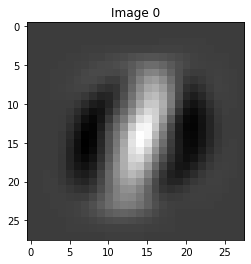

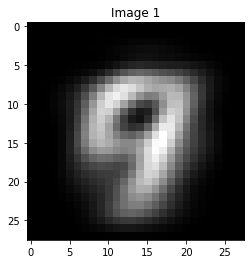

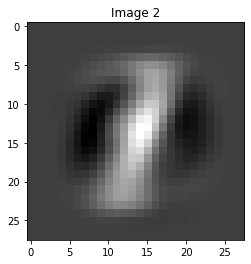

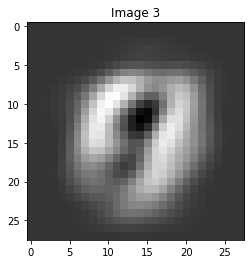

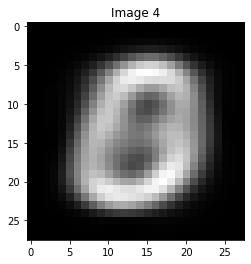

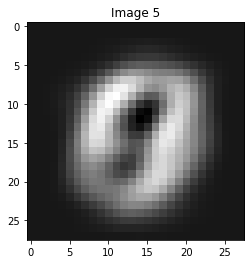

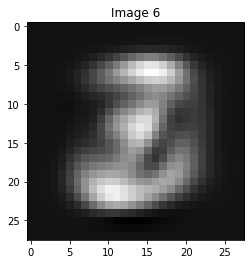

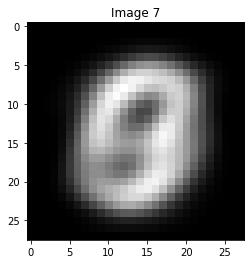

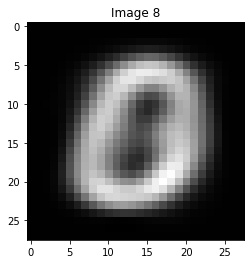

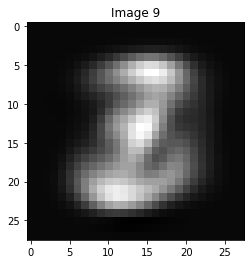

In [11]:
#Show sample data LSCV
showGenerateData(generatedDataPdfCV)


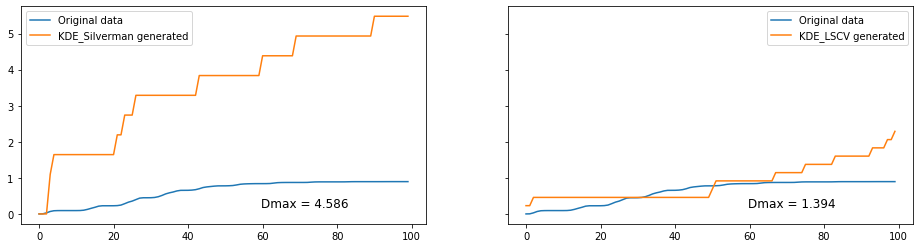

In [12]:
#K-S Statistics To Evaluate If Generated Data Is The Same Distribution As Dataset
hist,_ = np.histogramdd(data, bins=N, density=True)
hist1,_ = np.histogramdd(generatedDataPdfSilver, bins=N, density=True)
hist2, bins = np.histogramdd(generatedDataPdfCV, bins=N, density=True)
cumulative = np.cumsum(hist)*dx               #original dataset         
cumulativeKDE_Silverman = np.cumsum(hist1)*dx #KDE Silverman's h generated
cumulativeKDE_LSCV = np.cumsum(hist2)*dx      #KDE LSCV generated


DKDE_Silverman=np.max(np.absolute(cumulative-cumulativeKDE_Silverman))
DKDE_LSCV=np.max(np.absolute(cumulative-cumulativeKDE_LSCV))

fig, ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
ax[0].plot(cumulative, label="Original data")
ax[0].plot(cumulativeKDE_Silverman, label="KDE_Silverman generated")
ax[0].legend()
ax[0].set_title('Dmax = %.3f' % DKDE_Silverman, y=0.05, x=0.7)

ax[1].plot(cumulative, label="Original data")
ax[1].plot(cumulativeKDE_LSCV, label="KDE_LSCV generated")
ax[1].legend()
ax[1].set_title('Dmax = %.3f' % DKDE_LSCV, y=0.05, x=0.7)
plt.savefig("EvaluateDistribution.png")